Intensity vs Fermi Chopper frequency

Just try the original parameters

In [1]:
workdir = '~/dv/sns-chops/resolution/CNCS/mcvine'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/resolution/CNCS/mcvine


In [2]:
import numpy as np, os, sys, glob
from matplotlib import pyplot as plt

import histogram.hdf as hh, histogram as H
import mcvine, mcvine.components
from mcni.utils import conversion as C

from matplotlib import pyplot as plt
%matplotlib notebook

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Explore

In [3]:
def fc_tof(Ei):
    from numpy import sqrt, pi
    L1=6.413  
    T0=(1.0+Ei);
    T0=198.2*pow(T0,-0.84098)/1.e6;
    return T0+(2286.3*L1)/sqrt(Ei)/1.e6;
fc_tof(100)

0.0014702921765780608

In [4]:
fc_z = 6.413
fc_len = 0.017
mon_z = fc_z + fc_len + 0.01 
emin, emax = 5, 5.005
eave = (emin+emax)/2
v = C.e2v(eave)
tof = mon_z/v

instrument = mcvine.instrument()

In [5]:
source = mcvine.components.sources.SNS_source(
    'source', 
    S_filename='./a1Gw2-5-f5.dat', width=0.1, height=0.12, dist=0.98,
    xw=0.06, yh=0.11, Emin=emin, Emax=emax)
instrument.append(source, position=(0,0,0))

fc = mcvine.components.optics.FermiChopper(
    Nslit=9, zero_time=0, height=0.102, width=0.053, length=fc_len, time=fc_tof(eave), nu=60.)
instrument.append(fc, position=(0,0,fc_z))

monitor = mcvine.components.monitors.TOF_monitor2(
    'monitor', filename='Itof.dat', xmin=-0.04, xmax=0.04, ymin=-0.06, ymax=0.06, tmin=tof*.9, tmax=tof*1.5)
instrument.append(monitor, position=(0,0,mon_z))

In [6]:
%%time
# quick sim
neutrons = instrument.simulate(int(1e3),outputdir="out", overwrite_datafiles=True, iteration_no=0)

CPU times: user 131 ms, sys: 24.9 ms, total: 155 ms
Wall time: 392 ms


In [7]:
len(neutrons)

988

In [8]:
ls 

a1Gw2-5-f5.dat     beam-fwhms-SNS_source_r1.txt  Itof.dat
beam-fc-fwhms.txt  beam-fwhms.txt                out/


In [9]:
ls out/step0/

Itof.h5  number_of_mc_samples


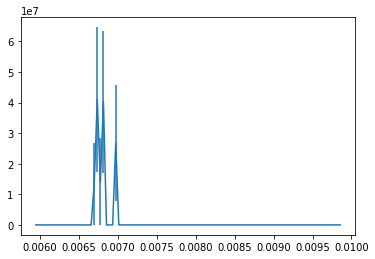

In [10]:
H.plot(hh.load('./out/step0/Itof.h5'))

# Loop

In [11]:
def calculatePulseShape(E, ncount=1e5):
    emin, emax = E*0.999, E*1.001
    eave = (emin+emax)/2
    v = C.e2v(eave)
    tof = mon_z/v

    instrument = mcvine.instrument()
    source = mcvine.components.sources.SNS_source(
        'source', 
        S_filename='./a1Gw2-5-f5.dat', width=0.1, height=0.12, dist=0.98,
        xw=0.06, yh=0.11, Emin=emin, Emax=emax)
    instrument.append(source, position=(0,0,0))

    fc = mcvine.components.optics.FermiChopper(
        Nslit=9, zero_time=0, height=0.102, width=0.053, length=fc_len, time=fc_tof(eave), nu=60.)
    instrument.append(fc, position=(0,0,fc_z))

    monitor = mcvine.components.monitors.TOF_monitor2(
        'monitor', filename='Itof.dat', xmin=-0.04, xmax=0.04, ymin=-0.06, ymax=0.06, tmin=tof*.95, tmax=tof*1.2,
        nchan=500,
    )
    instrument.append(monitor, position=(0,0,mon_z))
    #
    instrument.simulate(int(ncount),outputdir="out", overwrite_datafiles=True, iteration_no=0)
    return hh.load('./out/step0/Itof.h5')

In [12]:
%%time
h = calculatePulseShape(5.)

CPU times: user 2.11 s, sys: 55.3 ms, total: 2.17 s
Wall time: 2.17 s


In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


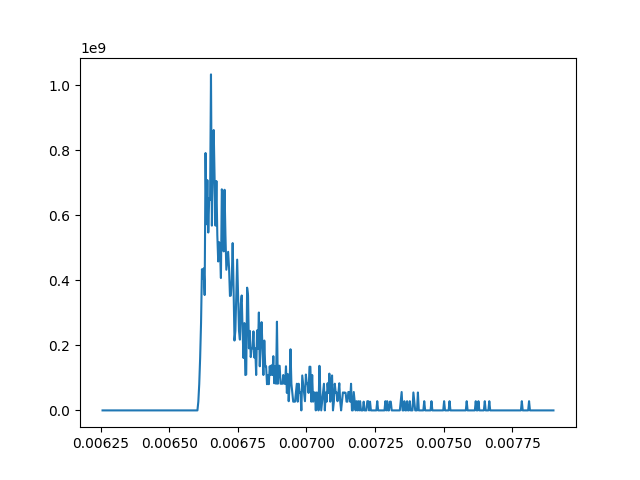

In [16]:
plt.figure()
plt.plot(h.tof, h.I)

In [17]:
Es = np.logspace(-1, 2)

In [18]:
import tqdm

In [19]:
spectra = []
for E in tqdm.tqdm(Es):
    spectra.append(calculatePulseShape(E, ncount=5e6))

100%|██████████| 50/50 [1:08:52<00:00, 80.95s/it]


In [20]:
len(Es)

50

<IPython.core.display.Javascript object>


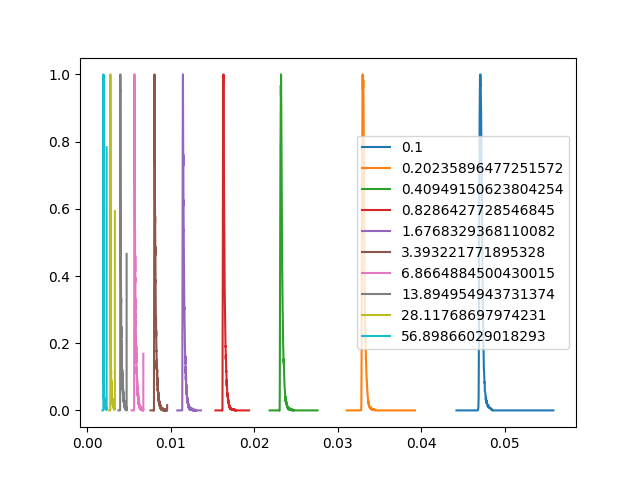

In [21]:
plt.figure()
for E, sp in zip(Es, spectra)[::5]:
    plt.plot(sp.tof, sp.I/sp.I.max(), label=E)
plt.legend()

<IPython.core.display.Javascript object>


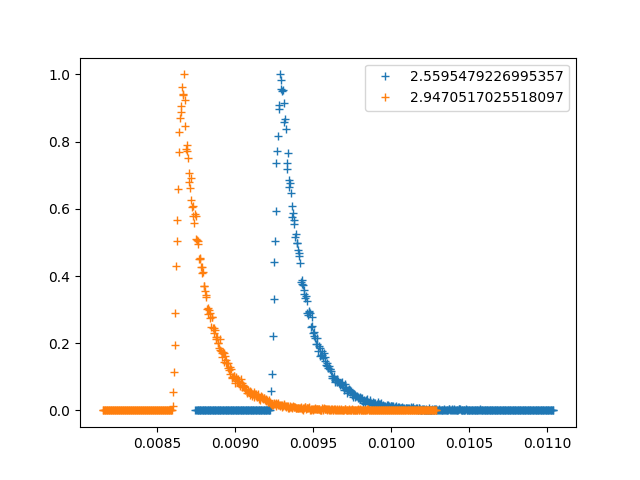

In [22]:
plt.figure()
for E, sp in zip(Es, spectra):
    if E<2.5 or E>3.2: continue
    plt.plot(sp.tof, sp.I/sp.I.max(), '+', label=E)
plt.legend()

In [23]:
fwhms = []
for E, sp in zip(Es, spectra):
    I = sp.I[:-5]; tof = sp.tof[:-5]
    max = I.max()
    hm = max/2
    top = tof[I>hm]
    fwhms.append(top[-1]-top[0])

In [24]:
fwhms = np.array(fwhms)

In [25]:
np.savetxt('beam-fc-fwhms.txt', np.array([Es, fwhms]).T)

In [26]:
beam_fwhms = np.loadtxt('beam-fwhms.txt')[:, 1]

<IPython.core.display.Javascript object>


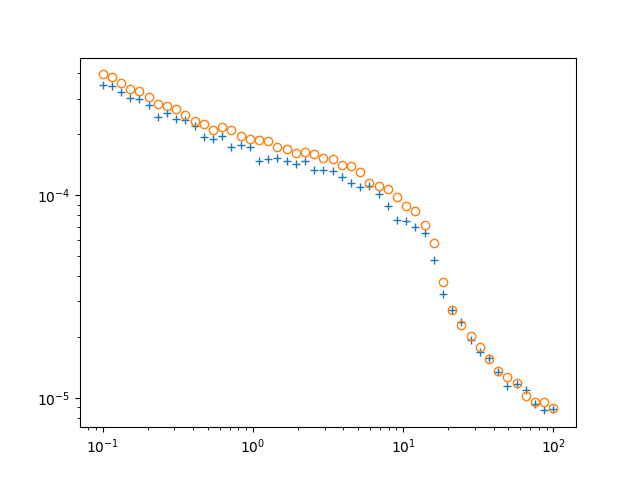

In [29]:
plt.figure()
plt.loglog(Es, fwhms, '+')
plt.loglog(Es, beam_fwhms, 'o', mfc='none')

<IPython.core.display.Javascript object>


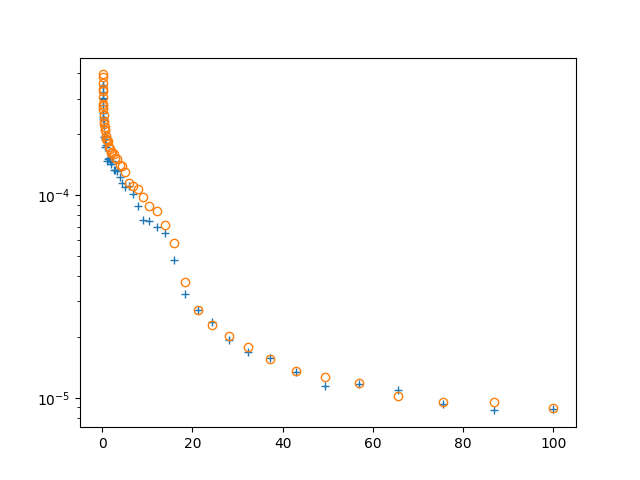

In [30]:
plt.figure()
plt.semilogy(Es, fwhms, '+')
plt.semilogy(Es, beam_fwhms, 'o', mfc='none')